# Predictions for Air Pollution

In this example, we will download [CAMS air pollution data](https://ads.atmosphere.copernicus.eu/datasets/cams-global-atmospheric-composition-forecasts) for 11 June 2022 at 0.4 degrees resolution and run Aurora Air Pollution on this data.

Running this notebook requires additional Python packages. You can install these as follows:

```
pip install cdsapi matplotlib
```

## Downloading the Data

To begin with, register an account with the [Atmosphere Data Store](https://ads.atmosphere.copernicus.eu/) and create `$HOME/.cdsapirc` with the following content:

```
url: https://ads.atmosphere.copernicus.eu/api
key: <API key>
```

You can find your API key on your account page.

In order to be able to download CAMS data, you need to accept the terms of use on the [dataset page](https://ads.atmosphere.copernicus.eu/datasets/cams-global-atmospheric-composition-forecasts?tab=download).


```{warning}
The URL in `$HOME/.cdsapirc` is `https://ads.atmosphere.copernicus.eu/api`, which conflicts with the URL `https://cds.climate.copernicus.eu/api` needed to download e.g. ERA5 data. You will need to manually switch between the URLs.
```

We now download the CAMS data.

In [1]:
import zipfile
from pathlib import Path

import cdsapi
from huggingface_hub import hf_hub_download

# Data will be downloaded here.
download_path = Path("~/downloads")

download_path = download_path.expanduser()
download_path.mkdir(parents=True, exist_ok=True)

# Download the static variables from HuggingFace.
static_path = hf_hub_download(
    repo_id="microsoft/aurora",
    filename="aurora-0.4-air-pollution-static.pickle",
)
print("Static variables downloaded!")

# Download the surface-level variables.
if not (download_path / "2022-06-11-cams.nc.zip").exists():
    c = cdsapi.Client()
    c.retrieve(
        "cams-global-atmospheric-composition-forecasts",
        {
            "type": "forecast",
            "leadtime_hour": "0",
            "variable": [
                # Meteorological surface-level variables:
                "10m_u_component_of_wind",
                "10m_v_component_of_wind",
                "2m_temperature",
                "mean_sea_level_pressure",
                # Pollution surface-level variables:
                "particulate_matter_1um",
                "particulate_matter_2.5um",
                "particulate_matter_10um",
                "total_column_carbon_monoxide",
                "total_column_nitrogen_monoxide",
                "total_column_nitrogen_dioxide",
                "total_column_ozone",
                "total_column_sulphur_dioxide",
                # Meteorological atmospheric variables:
                "u_component_of_wind",
                "v_component_of_wind",
                "temperature",
                "geopotential",
                "specific_humidity",
                # Pollution atmospheric variables:
                "carbon_monoxide",
                "nitrogen_dioxide",
                "nitrogen_monoxide",
                "ozone",
                "sulphur_dioxide",
            ],
            "pressure_level": [
                "50",
                "100",
                "150",
                "200",
                "250",
                "300",
                "400",
                "500",
                "600",
                "700",
                "850",
                "925",
                "1000",
            ],
            "date": "2022-06-11",
            "time": ["00:00", "12:00"],
            "format": "netcdf_zip",
        },
        str(download_path / "2022-06-11-cams.nc.zip"),
    )
# Unpack the ZIP. It should contain the surface-level and atmospheric data in separate
# files.
if not (download_path / "2022-06-11-cams-surface-level.nc").exists():
    with zipfile.ZipFile(download_path / "2022-06-11-cams.nc.zip", "r") as zf, open(
        download_path / "2022-06-11-cams-surface-level.nc", "wb"
    ) as f:
        f.write(zf.read("data_sfc.nc"))
if not (download_path / "2022-06-11-cams-atmospheric.nc").exists():
    with zipfile.ZipFile(download_path / "2022-06-11-cams.nc.zip", "r") as zf, open(
        download_path / "2022-06-11-cams-atmospheric.nc", "wb"
    ) as f:
        f.write(zf.read("data_plev.nc"))
print("Surface-level and atmospheric variables downloaded!")

Static variables downloaded!
Surface-level and atmospheric variables downloaded!


## Preparing a Batch

We convert the downloaded data to an `aurora.Batch`, which is what the model requires.

In [2]:
import pickle

import torch
import xarray as xr

from aurora import Batch, Metadata

with open(static_path, "rb") as f:
    static_vars = pickle.load(f)
surf_vars_ds = xr.open_dataset(
    download_path / "2022-06-11-cams-surface-level.nc", engine="netcdf4", decode_timedelta=True
)
atmos_vars_ds = xr.open_dataset(
    download_path / "2022-06-11-cams-atmospheric.nc", engine="netcdf4", decode_timedelta=True
)

# Select the zero-hour forecast to get the analysis product.
surf_vars_ds = surf_vars_ds.isel(forecast_period=0)
atmos_vars_ds = atmos_vars_ds.isel(forecast_period=0)

# The file has two time points: UTC 00 and UTC 12. We use both to construct the batch
# with time 2022-06-11 UTC 12.

batch = Batch(
    surf_vars={
        # `[None]` inserts a batch dimension of size one.
        "2t": torch.from_numpy(surf_vars_ds["t2m"].values[None]),
        "10u": torch.from_numpy(surf_vars_ds["u10"].values[None]),
        "10v": torch.from_numpy(surf_vars_ds["v10"].values[None]),
        "msl": torch.from_numpy(surf_vars_ds["msl"].values[None]),
        "pm1": torch.from_numpy(surf_vars_ds["pm1"].values[None]),
        "pm2p5": torch.from_numpy(surf_vars_ds["pm2p5"].values[None]),
        "pm10": torch.from_numpy(surf_vars_ds["pm10"].values[None]),
        "tcco": torch.from_numpy(surf_vars_ds["tcco"].values[None]),
        "tc_no": torch.from_numpy(surf_vars_ds["tc_no"].values[None]),
        "tcno2": torch.from_numpy(surf_vars_ds["tcno2"].values[None]),
        "gtco3": torch.from_numpy(surf_vars_ds["gtco3"].values[None]),
        "tcso2": torch.from_numpy(surf_vars_ds["tcso2"].values[None]),
    },
    static_vars={k: torch.from_numpy(v) for k, v in static_vars.items()},
    atmos_vars={
        "t": torch.from_numpy(atmos_vars_ds["t"].values[None]),
        "u": torch.from_numpy(atmos_vars_ds["u"].values[None]),
        "v": torch.from_numpy(atmos_vars_ds["v"].values[None]),
        "q": torch.from_numpy(atmos_vars_ds["q"].values[None]),
        "z": torch.from_numpy(atmos_vars_ds["z"].values[None]),
        "co": torch.from_numpy(atmos_vars_ds["co"].values[None]),
        "no": torch.from_numpy(atmos_vars_ds["no"].values[None]),
        "no2": torch.from_numpy(atmos_vars_ds["no2"].values[None]),
        "go3": torch.from_numpy(atmos_vars_ds["go3"].values[None]),
        "so2": torch.from_numpy(atmos_vars_ds["so2"].values[None]),
    },
    metadata=Metadata(
        lat=torch.from_numpy(atmos_vars_ds.latitude.values),
        lon=torch.from_numpy(atmos_vars_ds.longitude.values),
        # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
        # `datetime.datetime`s.
        time=(atmos_vars_ds.valid_time.values.astype("datetime64[s]").tolist()[-1],),
        atmos_levels=tuple(int(level) for level in atmos_vars_ds.pressure_level.values),
    ),
)

/tmp/ipykernel_2130273/3507667540.py:9: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  static_vars = pickle.load(f)


## Loading and Running the Model

Finally, we are ready to load and run the model and visualise the predictions. We perform a roll-out for four steps, which produces predictions for 12 June 2022 UTC 00 and UTC 12 and 13 June 2022 UTC 00 and UTC 12.

The model can be run locally, or run on Azure AI Foundry. To run on Foundry, the environment variables `FOUNDRY_ENDPOINT`, `FOUNDRY_TOKEN`, and `BLOB_URL_WITH_SAS` need to be set. If you're unsure on how to set environment variables, see [here](./foundry/intro.md), or simply copy paste your keys below (but be sure not to commit any keys)! 

In [10]:
# set this according to preference
run_on_foundry = True

In [ ]:
if not run_on_foundry:
    from aurora import AuroraAirPollution, rollout

    model = AuroraAirPollution()
    model.load_checkpoint("microsoft/aurora", "aurora-0.4-air-pollution.ckpt")

    model.eval()
    model = model.to("cuda")

    with torch.inference_mode():
        predictions = [pred.to("cpu") for pred in rollout(model, batch, steps=4)]

    model = model.to("cpu")
else:
    import logging
    import os
    import warnings

    from aurora.foundry import BlobStorageChannel, FoundryClient, submit

    # In this demo, we silence all warnings.
    warnings.filterwarnings("ignore")

    # But we do want to show what's happening under the hood!
    logging.basicConfig(level=logging.WARNING, format="%(asctime)s [%(levelname)s] %(message)s")
    logging.getLogger("aurora").setLevel(logging.INFO)

    foundry_client = FoundryClient(
        endpoint=os.environ["FOUNDRY_ENDPOINT"],
        token=os.environ["FOUNDRY_TOKEN"],
    )
    channel = BlobStorageChannel(os.environ["BLOB_URL_WITH_SAS"])

    predictions = list(
        submit(
            batch,
            model_name="aurora-0.4-air-pollution",
            num_steps=4,
            foundry_client=foundry_client,
            channel=channel,
        )
    )

2025-06-03 15:08:18,573 [INFO] Created task `c44c427e-a0c8-4f61-ab28-caba0d1fab56` at endpoint.
2025-06-03 15:08:18,574 [INFO] Uploading initial condition.
2025-06-03 15:08:39,653 [INFO] Task status update: Queued
2025-06-03 15:08:42,879 [INFO] Task status update: Running
2025-06-03 15:09:19,381 [INFO] Task progress update: 25%.
2025-06-03 15:09:32,266 [INFO] Task progress update: 50%.
2025-06-03 15:09:48,370 [INFO] Task progress update: 75%.
2025-06-03 15:10:00,220 [INFO] Task status update: Successfully completed
2025-06-03 15:10:00,221 [INFO] Task progress update: 100%.
2025-06-03 15:10:00,221 [INFO] Task has been successfully completed!
2025-06-03 15:10:00,221 [INFO] Retrieving predictions.
2025-06-03 15:10:46,293 [INFO] All predictions have been retrieved.


### Plotting the Results

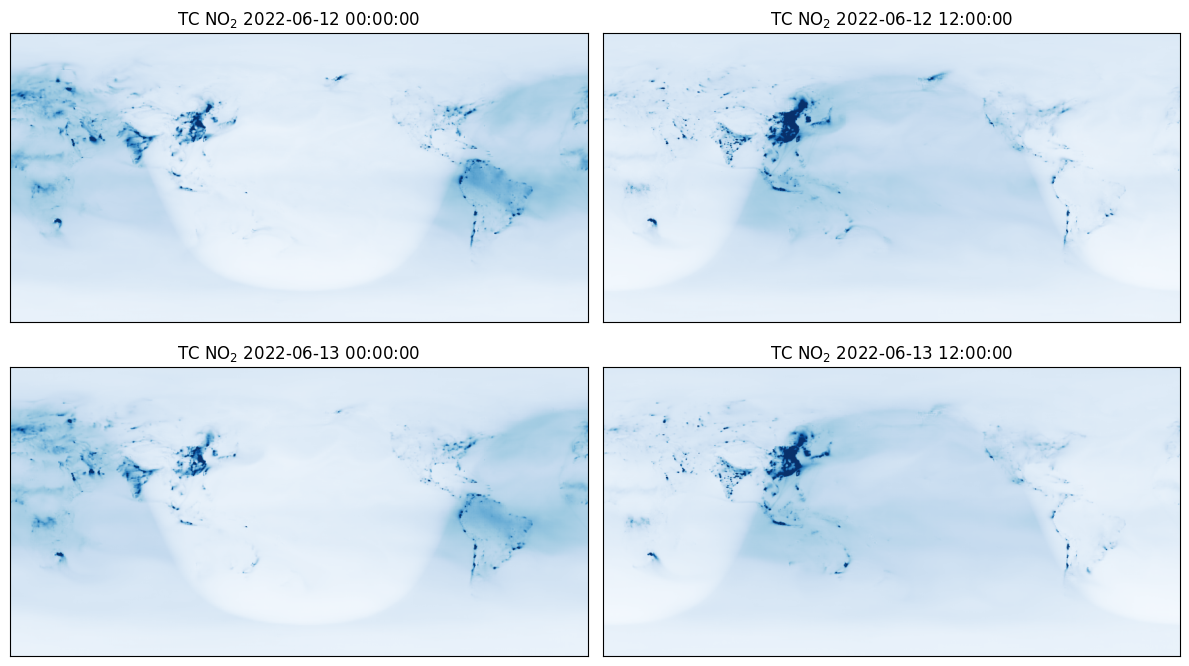

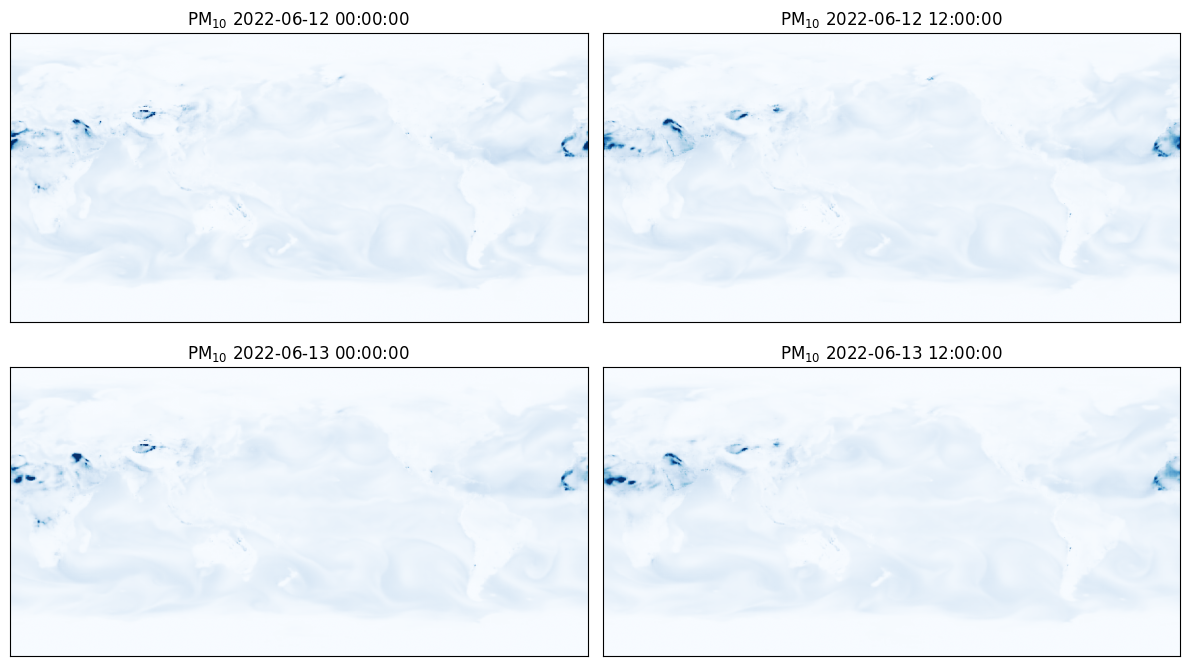

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 7))

for i in range(4):
    ax = axs[i // 2, i % 2]
    pred = predictions[i]
    ax.imshow(pred.surf_vars["tcno2"][0, 0].numpy() / 1e-6, vmin=0, vmax=10, cmap="Blues")
    ax.set_title(f"TC NO${{}}_2$ {pred.metadata.time[0]}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

fig, axs = plt.subplots(2, 2, figsize=(12, 7))

for i in range(4):
    ax = axs[i // 2, i % 2]
    pred = predictions[i]
    ax.imshow(pred.surf_vars["pm10"][0, 0].numpy() / 1e-9, vmin=0, vmax=400, cmap="Blues")
    ax.set_title(f"PM${{}}_{{10}}$ {pred.metadata.time[0]}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()